In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

In [2]:
df = pd.read_csv("Reliance_stock_price.csv")


In [3]:
df=df.drop("Unnamed: 0",axis=1)

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,438.988831,441.812073,437.676270,439.781311,417.988892,1367720
1,2015-01-02,439.880371,443.818054,437.998199,438.617340,416.882629,3383424
2,2015-01-05,438.344940,441.267212,432.946106,433.812897,412.316223,4662967
3,2015-01-06,430.915344,432.401276,412.093750,414.124512,393.603455,8596809
4,2015-01-07,414.619812,425.367950,414.570282,423.139069,402.171295,9562421


## Checking Resampling and Interpolation
* So, in this dataset we have daily basis stock price and our objective is also forecast the next 30 days stck price so here we don't need to change the low frequency --> High freq. OR High frequency --> Low frequency

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1976.000000,1976.000000,1976.000000,1976.000000,1976.000000,1.976000e+03
mean,1315.801554,1330.795265,1300.182943,1314.889481,1300.448647,9.088830e+06
std,752.202151,760.497187,743.372182,751.597730,755.782725,6.693435e+06
min,404.466064,405.010895,394.485657,401.568542,381.669708,7.871600e+05
25%,530.180679,537.337814,525.989166,531.945190,516.012283,5.242449e+06
50%,1171.396301,1187.840454,1151.435547,1171.445862,1155.124390,7.149341e+06
75%,2043.350037,2065.924988,2003.612518,2034.700012,2023.652771,1.024994e+07
max,2856.149902,2856.149902,2786.100098,2819.850098,2811.385742,6.584835e+07


In [6]:
df["Date"]=pd.to_datetime(df["Date"])
df["Year"]=df["Date"].dt.year

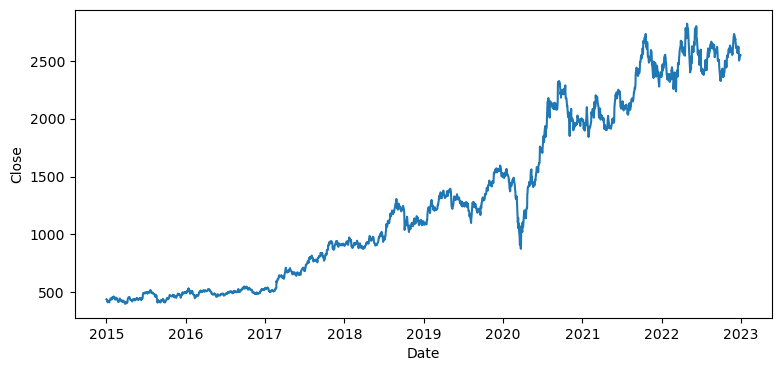

In [7]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(9,4))
sns.lineplot(df["Date"],df["Close"])
plt.show()

###### In the above fig. we see that mean and variance of the observations changes over time. This makes it difficult to model for both classsical statistical methods, like ARIMA, and more sophisticated ML methods like NN. So here we need a transformation

In [8]:
df_new=df[["Date","Close"]]
df_new.head()

,Date,Close
0,2015-01-01,439.781311
1,2015-01-02,438.617340
2,2015-01-05,433.812897
3,2015-01-06,414.124512
4,2015-01-07,423.139069


In [9]:
df_new["Close"]=np.sqrt(df_new["Close"])

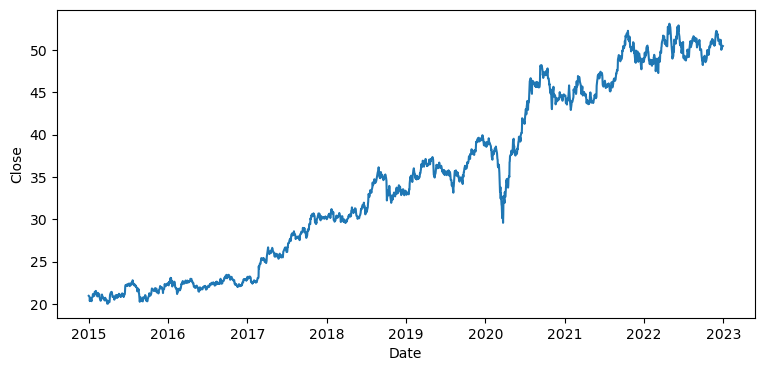

In [10]:
plt.figure(figsize=(9,4))
sns.lineplot(df_new["Date"],df_new["Close"])
plt.show()

In [11]:
df_new.head()

,Date,Close
0,2015-01-01,20.970964
1,2015-01-02,20.943193
2,2015-01-05,20.828176
3,2015-01-06,20.350049
4,2015-01-07,20.570344


# Splitting data

##### Split the last year into a test set- to build a model to predict stock price

##### For splitting the dataset in time series we never divide the data randomly. We only divide the dataset sequencely. Because we have some pattern in the time series.

In [42]:
Train = df.head(1728)
Test = df.tail(248)

In [13]:
Train

,Date,Open,High,Low,Close,Adj Close,Volume,Year
0,2015-01-01,438.988831,441.812073,437.676270,439.781311,417.988892,1367720,2015
1,2015-01-02,439.880371,443.818054,437.998199,438.617340,416.882629,3383424,2015
2,2015-01-05,438.344940,441.267212,432.946106,433.812897,412.316223,4662967,2015
3,2015-01-06,430.915344,432.401276,412.093750,414.124512,393.603455,8596809,2015
4,2015-01-07,414.619812,425.367950,414.570282,423.139069,402.171295,9562421,2015
...,...,...,...,...,...,...,...,...
1723,2021-12-27,2361.550049,2378.000000,2348.100098,2370.250000,2363.135254,1853948,2021
1724,2021-12-28,2375.600098,2404.850098,2373.050049,2398.399902,2391.200684,2941883,2021
1725,2021-12-29,2391.000000,2419.000000,2382.100098,2402.500000,2395.288330,7118779,2021
1726,2021-12-30,2400.000000,2404.949951,2345.600098,2359.100098,2352.018799,13537254,2021


In [43]:
Test.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year
1728,2022-01-03,2365.000000,2407.949951,2363.550049,2403.850098,2396.634521,2502073,2022
1729,2022-01-04,2415.899902,2461.000000,2404.000000,2458.100098,2450.721680,5006225,2022
1730,2022-01-05,2462.000000,2477.000000,2432.949951,2469.600098,2462.187012,5373618,2022
1731,2022-01-06,2451.199951,2454.000000,2409.000000,2416.500000,2409.246338,6667483,2022
1732,2022-01-07,2430.949951,2458.050049,2411.550049,2436.000000,2428.687988,6051239,2022


# Moving Average 

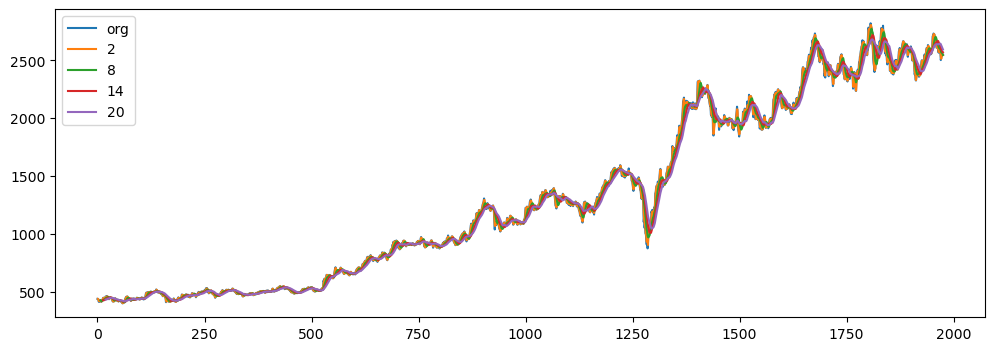

In [15]:
plt.figure(figsize=(12,4))
df.Close.plot(label="org")
for i in range(2,24,6):
    df["Close"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

# Time series decomposition plot 


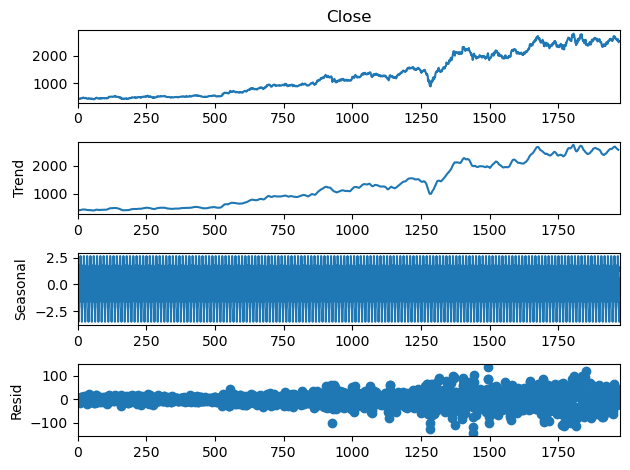

In [16]:
decompose_ts_add = seasonal_decompose(df.Close,period=12)
decompose_ts_add.plot()
plt.show()

# ACF plots and PACF plots


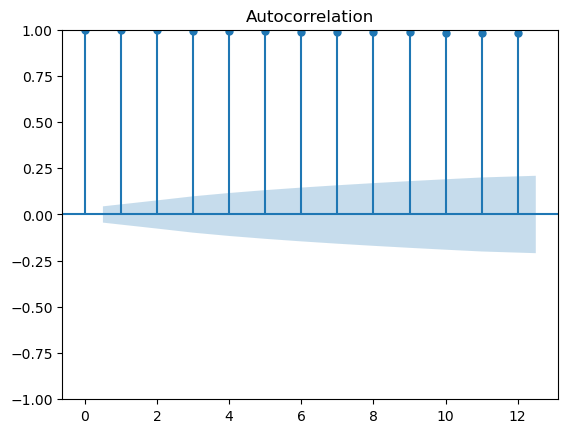

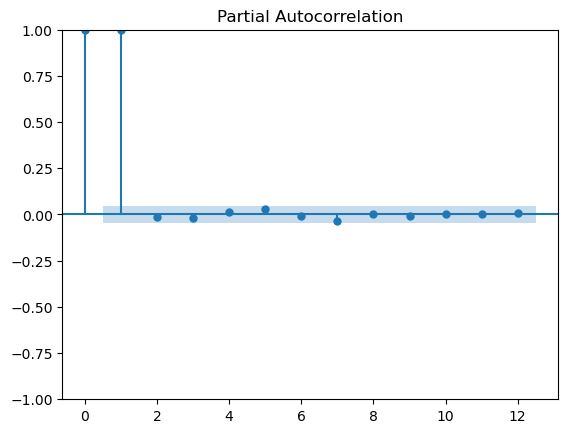

In [17]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(df.Close,lags=12)
tsa_plots.plot_pacf(df.Close,lags=12)
plt.show()


#### Here you see in a PACF plot p=2(lag is 2 here and this are significant and rest are insignificant)

### Evaluation Metric MAPE

In [18]:
def MAPE(pred,org):#Mean absolute percentage error
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

### Autoregressive model
* Here this model is used because:-
   In this dataset we see in ACF plot all have non zero at all lags.
   But in PACF first two are non zero and the rest are zero.

In [19]:
from statsmodels.tsa.ar_model import AutoReg
model_AR=AutoReg(Train['Close'],lags=2).fit()
pred_AR=model_AR.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_AR,Test.Close) 


3.8364390442670917

### Simple Exponential Method


In [20]:
ses_model = SimpleExpSmoothing(Train["Close"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Close) 


6.273868303861915

### Holt method 
* Trend dataset

In [21]:
# Holt method 
hw_model = Holt(Train["Close"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Close) 

12.571345699664503

### Holts winter exponential smoothing with additive seasonality and additive trend


In [22]:
hwe_model_add_add = ExponentialSmoothing(Train["Close"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Close) 

4.380699010294386

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [23]:
hwe_model_mul_add = ExponentialSmoothing(Train["Close"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Close)

3.8403724957676513

In [24]:
errors=pd.DataFrame({"MAPE's":[MAPE(pred_AR,Test.Close) 
,MAPE(pred_ses,Test.Close),MAPE(pred_hw,Test.Close),MAPE(pred_hwe_add_add,Test.Close) ,MAPE(pred_hwe_mul_add,Test.Close)]},index=["AR","SIMPLE_EXP","Holt's","hwe_model_add_add","hwe_model_mul_add"])
errors.sort_values("MAPE's")


,MAPE's
AR,3.836439
hwe_model_mul_add,3.840372
hwe_model_add_add,4.380699
SIMPLE_EXP,6.273868
Holt's,12.571346


#### So here "Autoregressive model" is the lowest MAPE 

## Final Model by combining train and test

In [25]:
model_AR=AutoReg(df['Close'],lags=2).fit()


In [26]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Year
1971,2022-12-26,2514.750000,2542.000000,2492.399902,2524.050049,2524.050049,2764496,2022
1972,2022-12-27,2530.000000,2548.800049,2515.250000,2544.699951,2544.699951,2659749,2022
1973,2022-12-28,2538.000000,2549.800049,2521.500000,2544.449951,2544.449951,3442509,2022
1974,2022-12-29,2527.000000,2548.899902,2525.500000,2543.300049,2543.300049,3198493,2022
1975,2022-12-30,2545.100098,2577.000000,2541.100098,2547.199951,2547.199951,3364092,2022


In [27]:
prediction_30_AR=model_AR.predict(1976,2006)

In [28]:
df_30_pred_AR=pd.DataFrame(prediction_30_AR,columns=["values"])


In [29]:
p=df_30_pred_AR["values"].values
len(p)

31

In [30]:
o=df["Close"]


In [31]:
day_new=np.arange(1,1977)
day_pred=np.arange(1977,2008)


In [32]:
(len(day_new),len(day_pred)) ,(len(o),len(p))



((1976, 31), (1976, 31))

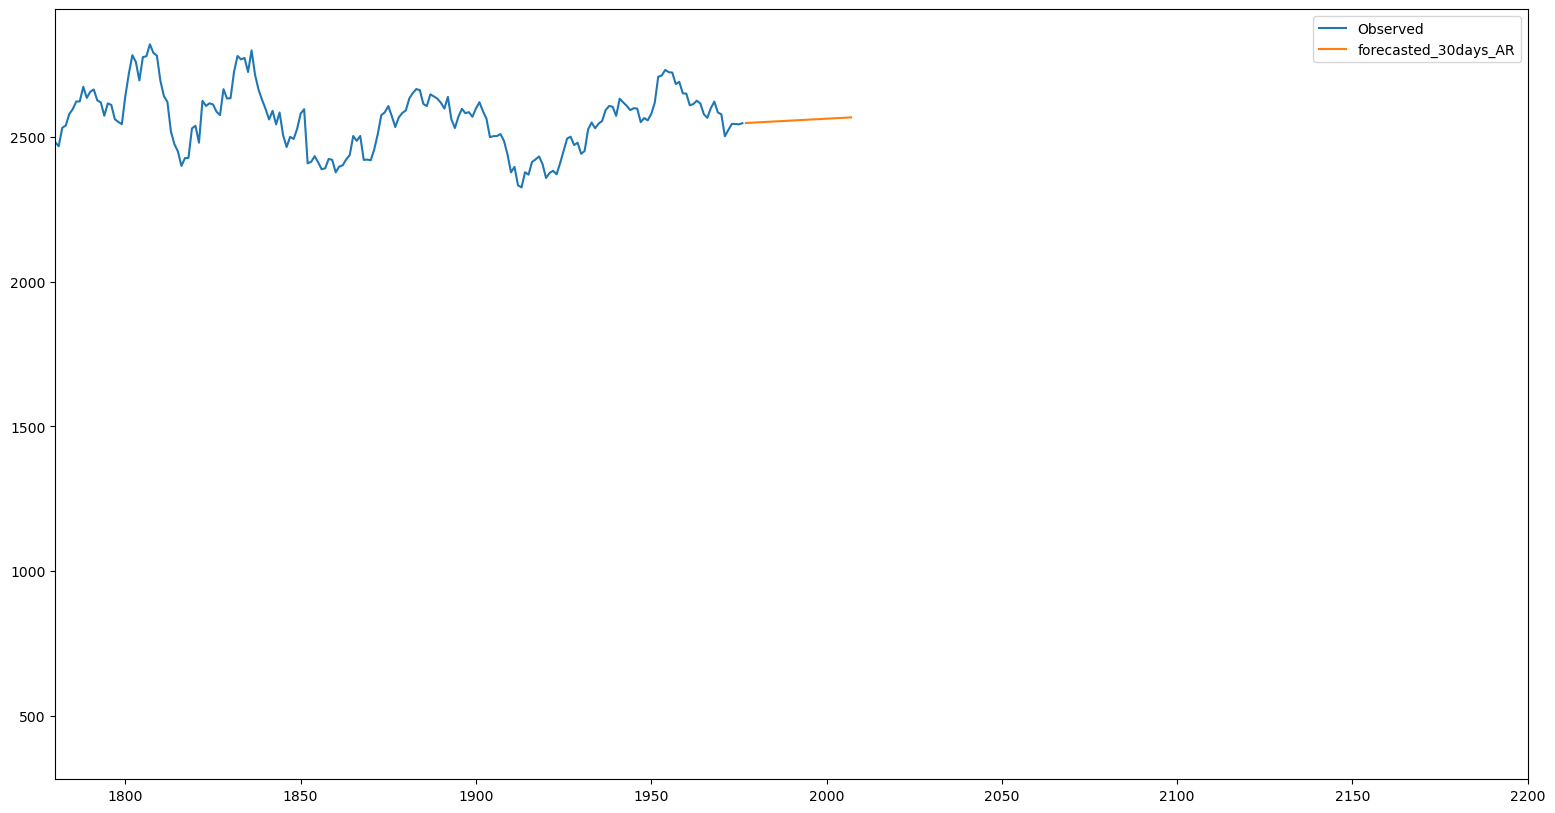

In [33]:

plt.figure(figsize=(19,10))
plt.plot(day_new,o,label="Observed")
plt.plot(day_pred,p,label='forecasted_30days_AR')
plt.xlim(1780,2200)
plt.legend()
plt.show()

### Also checking the "Holts winter exponential smoothing with multiplicative seasonality and additive trend" in the final model

In [34]:
hwe_model_mul_add = ExponentialSmoothing(df["Close"],seasonal="mul",trend="add",seasonal_periods=12).fit()


In [35]:
#Forecasting for next 30 
prediction_30_EXP=[]
for i in range (1976,2007):
    prediction_30_EXP.append(hwe_model_mul_add.predict(i).values)
    


In [36]:
df_30_pred_EXP=pd.DataFrame(prediction_30_EXP,columns=["values"])


In [37]:

p=df_30_pred_EXP["values"].values
len(p)


31

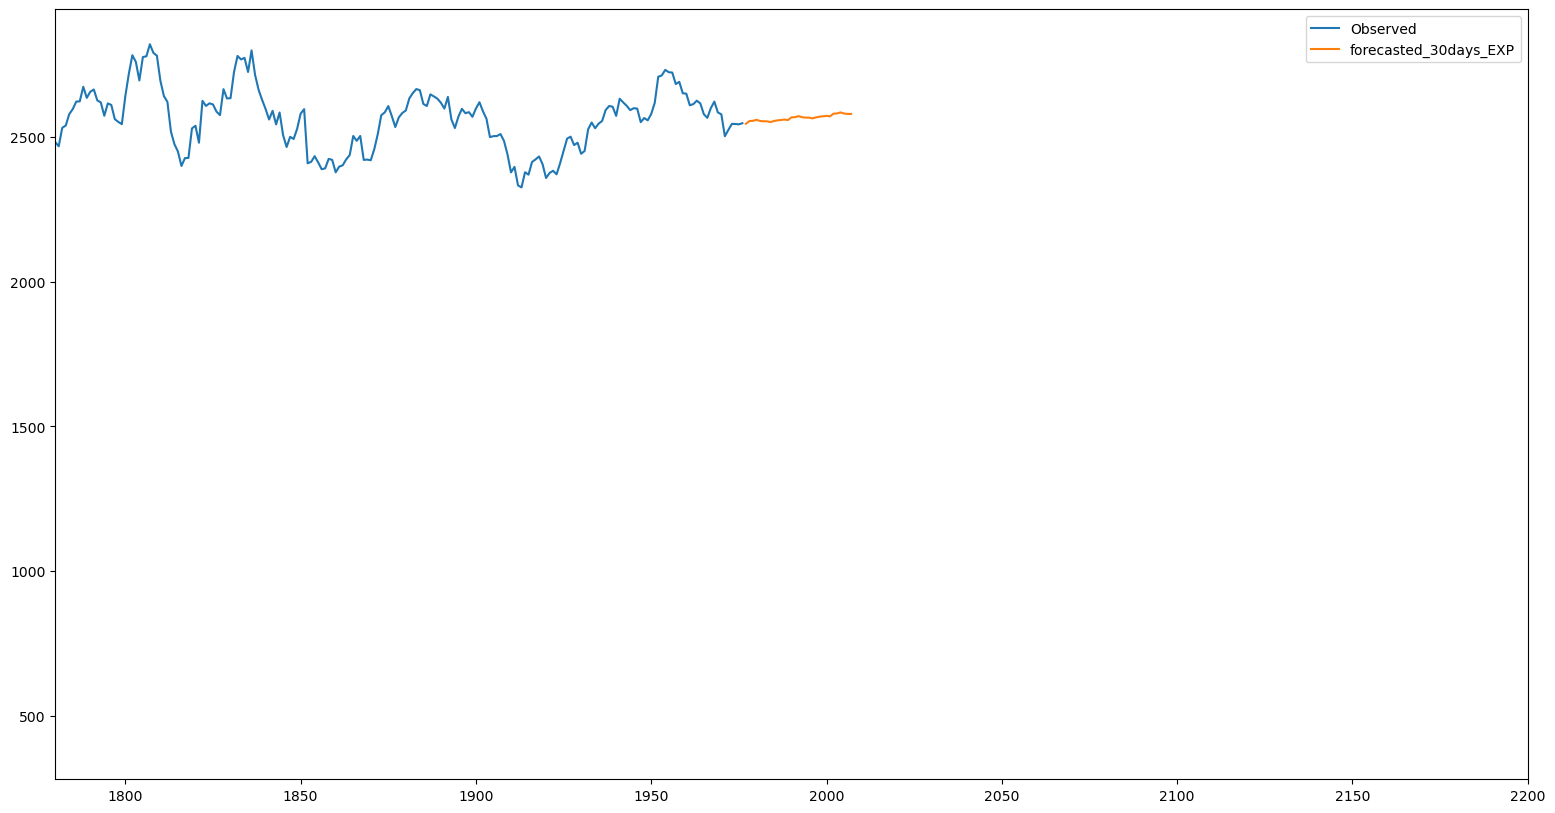

In [38]:

day_new=np.arange(1,1977)
day_pred=np.arange(1977,2008)

len(day_new),len(day_pred)

len(o),len(p)

plt.figure(figsize=(19,10))
plt.plot(day_new,o,label="Observed")
plt.plot(day_pred,p,label='forecasted_30days_EXP')
plt.xlim(1780,2200)
plt.legend()
plt.show()

### Next 30 days prediction

In [39]:
len(prediction_30_AR),len(prediction_30_EXP)

(31, 31)

In [40]:
dates_30=pd.date_range(start='1/1/2023', end='31/01/2023')

In [41]:
pd.DataFrame({"Forecasted_30_AR":prediction_30_AR.values,"Forecasted_30_EXP":prediction_30_EXP},index=dates_30)

,Forecasted_30_AR,Forecasted_30_EXP
2023-01-01,2547.910645,[2545.2870785199793]
2023-01-02,2548.558910,[2554.62157971777]
2023-01-03,2549.205740,[2555.324581055446]
2023-01-04,2549.852325,[2558.8707734582667]
2023-01-05,2550.498690,[2555.0950166697608]
2023-01-06,2551.144833,[2553.8192383943306]
2023-01-07,2551.790756,[2553.7214865910605]
2023-01-08,2552.436458,[2551.2090535042053]
2023-01-09,2553.081939,[2554.641287492457]
2023-01-10,2553.727201,[2557.0045697158143]
